In [195]:
import pandas as pd
import numpy as np
import os
import sys
from trimesh import load_mesh
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps
from utils.combine_tools import apply_qc, to_str_intlike
import matplotlib.pyplot as plt
import k3d
import json
from matplotlib.colors import LinearSegmentedColormap
# two sample t test
from scipy.stats import ttest_ind
import pickle
%matplotlib inline

In [159]:
data_dir = '/root/capsule/scratch/combined/retro_ccf/manual_proofread_ccf_18brains.csv'
retro_ccf = pd.read_csv(data_dir)
save_dir = '/root/capsule/scratch/combined/retro_ccf/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
retro_ccf.groupby(['injection_region']).count()

brain  channel     x     y     z
injection_region                                  
CB                 3828     3828  3828  3828  3828
CTX                2714     2714  2714  2714  2714
SP                 3177     3177  3177  3177  3177
TH                 2211     2211  2211  2211  2211

In [152]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
bregma_pixel = np.array([216, 18, 228])
norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - bregma_pixel)*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm_flip = mesh_vertices_mm.copy()
mesh_vertices_mm_flip[:, ml] = -mesh_vertices_mm[:, ml]
mesh_vertices_mm_left = mesh_vertices_mm.copy()
mesh_vertices_mm_left[:, ml] = np.abs(mesh_vertices_mm[:, ml])
mesh_vertices_mm = np.concatenate([mesh_vertices_mm, mesh_vertices_mm_flip], axis=0)
# mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]

In [108]:
bregma_pixel_retro = np.array([228, 18, 216])
ccf_neurons_mm = (retro_ccf[['x', 'y', 'z']].values - bregma_pixel_retro) * 25 / 1000  # convert to mm
ccf_neurons_mm[:, [dv, ap]] = ccf_neurons_mm[:, [ap, dv]]  # Mirror ML to left
ccf_neurons_mm[:, dv] = -ccf_neurons_mm[:, dv]  # Mirror ML to left


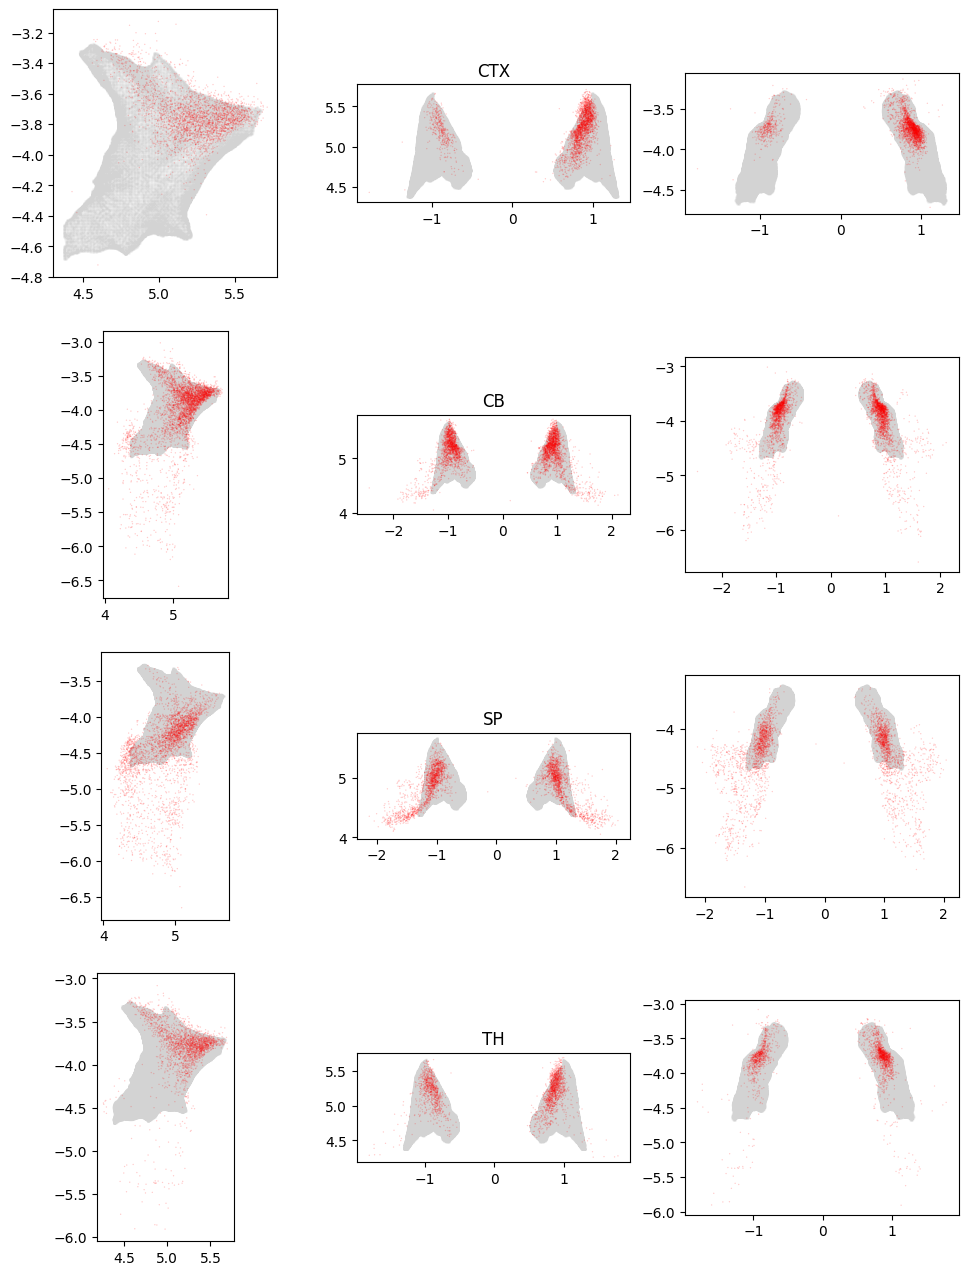

In [7]:
fig = plt.figure(figsize=(12, 4*len(retro_ccf['injection_region'].unique())))
gs = fig.add_gridspec(len(retro_ccf['injection_region'].unique()), 3)
for plane, ax_ind in zip(planes.keys(), range(3)):
    # ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    for ind, tar in enumerate(retro_ccf['injection_region'].unique()):
        mask = (retro_ccf['injection_region'] == tar)
        ax = fig.add_subplot(gs[ind, ax_ind])
        ax.scatter(mesh_vertices_mm[:, planes[plane][0]], mesh_vertices_mm[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.1)
        
        sc = ax.scatter(ccf_neurons_mm[mask, planes[plane][0]], ccf_neurons_mm[mask, planes[plane][1]], color='r', alpha=0.2, s=1, edgecolor='none', label=tar)
        ax.set_aspect(aspect='equal')
        if plane == 'hor':
            ax.set_title(tar)
    # ax.set_title(plane)

In [104]:
# create a filter by within certain distance to the mesh
distance_threshold = 0.2  # in mm
from scipy.spatial import cKDTree
mesh_kd_tree = cKDTree(mesh_vertices_mm)
distances, _ = mesh_kd_tree.query(ccf_neurons_mm, k=1)
close_to_mesh_mask = distances < distance_threshold


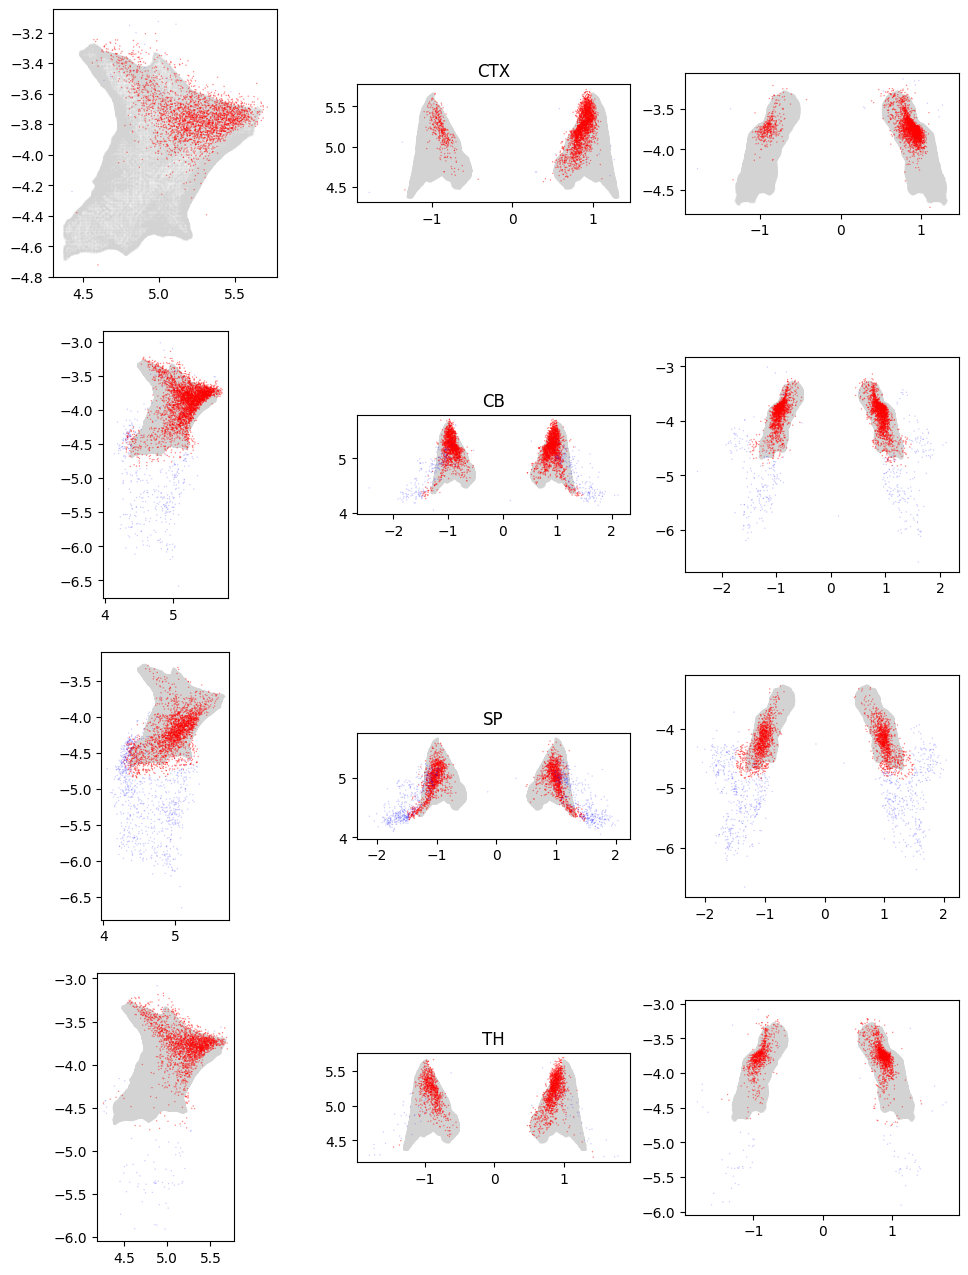

In [9]:
# plot masked and unmasked points
fig = plt.figure(figsize=(12, 4*len(retro_ccf['injection_region'].unique())))
gs = fig.add_gridspec(len(retro_ccf['injection_region'].unique()), 3)
for plane, ax_ind in zip(planes.keys(), range(3)):
    # ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    for ind, tar in enumerate(retro_ccf['injection_region'].unique()):
        mask = (retro_ccf['injection_region'] == tar)
        ax = fig.add_subplot(gs[ind, ax_ind])
        ax.scatter(mesh_vertices_mm[:, planes[plane][0]], mesh_vertices_mm[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.1)
        
        sc = ax.scatter(ccf_neurons_mm[mask & close_to_mesh_mask, planes[plane][0]], ccf_neurons_mm[mask & close_to_mesh_mask, planes[plane][1]], color='r', alpha=0.5, s=1, edgecolor='none', label=tar)
        sc2 = ax.scatter(ccf_neurons_mm[mask & ~close_to_mesh_mask, planes[plane][0]], ccf_neurons_mm[mask & ~close_to_mesh_mask, planes[plane][1]], color='b', alpha=0.2, s=1, edgecolor='none', label=tar)
        ax.set_aspect(aspect='equal')
        if plane == 'hor':
            ax.set_title(tar)
    # ax.set_title(plane)
plt.show()

In [10]:
# plot in 3d space using k3d
plot = k3d.plot()
# transparent gray mesh
plot += k3d.points(mesh_vertices_mm.astype(np.float32), point_size=0.001, shader='flat', color=0xAAAAAA, opacity=0.1, name='CCF Mesh')
# plot neurons projecting to each region in different colors
colors = [0xFF0000, 0x00FF00, 0x0000FF, 0xFFFF00, 0x00FFFF, 0xFF00FF, 0x880000, 0x008800, 0x000088]
for ind, tar in enumerate(retro_ccf['injection_region'].unique()):
    mask = (retro_ccf['injection_region'] == tar)
    plot += k3d.points(ccf_neurons_mm[mask&close_to_mesh_mask].astype(np.float32), point_size=0.03, shader='flat', color=colors[ind % len(colors)], name=tar, opacity=0.5)
plot.display()

Output()

In [14]:
# # # Step 1: Extract the relevant data
# # coordinates = df_ipsi[['RC', 'DV', 'ML']].values
# projection_regions = retro_ccf['injection_region'].values
# filter = (projection_regions!="TH") & (ccf_neurons_mm[:, dv_mesh] <= 4.8) & (projection_regions != 'CB')
# # # Step 2: Perform PCA
# # pca = PCA(n_components=3)
# # pca_result = pca.fit_transform(coordinates)
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# # Step 3: Perform LDA on the PCA result
# lda = LinearDiscriminantAnalysis(n_components=1)
# lda_result = lda.fit_transform(ccf_neurons_mm[filter], projection_regions[filter])

In [15]:
# # change projection regions to numbers
# projection_regions_num = np.zeros_like(projection_regions)
# for i, region in enumerate(np.unique(projection_regions)):
#     projection_regions_num[projection_regions == region] = i

In [16]:
# plt.figure()
# plt.scatter(lda_result[:, 0], lda_result[:, 1], c=projection_regions_num[filter], cmap='viridis', alpha=0.5, s = 5)
# # plt histogram of projection regions along the first LDA axis
# plt.figure()
# for i, region in enumerate(np.unique(projection_regions)):
#     plt.hist(lda_result[projection_regions_num[filter] == i, 0], bins=50, alpha=0.5, label=region, density=True)
# plt.legend()

# Compare unit location between retro data vs recording data

## Compare dorsal edge

In [17]:
# plot dorsal_edge of LC labeled by hand
txt_file = "/root/capsule/code/data_management/animal_ids.txt"

with open(txt_file) as f:
    animal_ids = [line.strip() for line in f if line.strip()]

In [57]:
from scipy.interpolate import RBFInterpolator
distance_threshold = 0.15
kernel="linear"
smoothing = 0.2
epsilon = 0.5 
concat_dorsal_edge = []
concat_dorsal_surface_L = []
concat_dorsal_surface_R = []
for animal_id in animal_ids:
    dorsal_edge_json = f'/root/capsule/data/dorsal_edges/{animal_id}_dorsal_edge_ccf_fix.json'
    if os.path.exists(dorsal_edge_json):
        with open(dorsal_edge_json, 'r') as f:
            dorsal_edge_dict = json.load(f)
        # make into a dataframe
        dorsal_edge_df = pd.DataFrame(dorsal_edge_dict['xyz_picks'], columns=['x', 'y', 'z'])
        # make into a dataframe
        dorsal_edge_mat = dorsal_edge_df.values
        dorsal_edge_mat[:, 0] = dorsal_edge_mat[:, 0]
        # dorsal_edge_mat[:, ml]  = np.abs(dorsal_edge_mat[:, ml])
        concat_dorsal_edge.append(dorsal_edge_mat)

        dorsal_edge_L = dorsal_edge_mat[dorsal_edge_mat[:, ml]>0]
        dorsal_edge_R = dorsal_edge_mat[dorsal_edge_mat[:, ml]<0]

        # infer a plain surface from the dorsal edge points using smoothing spline

        X_L = dorsal_edge_L[:, [ap, dv]]
        y_L = dorsal_edge_L[:, ml]

        rbf_L = RBFInterpolator(
            X_L, y_L,
            kernel=kernel,   # often nicer than "linear"
            smoothing=smoothing,                # 0 == interpolate exactly
            neighbors=10,            # tune: 20–100 typical
            epsilon=epsilon
        )

        X_R = dorsal_edge_R[:, [ap, dv]]
        y_R = dorsal_edge_R[:, ml]
        rbf_R = RBFInterpolator(
            X_R, y_R,
            kernel=kernel,
            smoothing=smoothing,
            neighbors=10,
            epsilon=epsilon
        )
        ap_grid = np.linspace(np.min(dorsal_edge_mat[:, ap]), np.max(dorsal_edge_mat[:, ap]), 50)
        dv_grid = np.linspace(np.min(dorsal_edge_mat[:, dv]), np.max(dorsal_edge_mat[:, dv]), 50)
        AP, DV = np.meshgrid(ap_grid, dv_grid)
        # get rid of points too far from the dorsal edge points, 0.2 mm away
        dorsal_edge_kd_tree_L = cKDTree(dorsal_edge_L[:, [ap, dv]])
        dorsal_edge_kd_tree_R = cKDTree(dorsal_edge_R[:, [ap, dv]])
        query_pts_all = np.column_stack([AP.ravel(), DV.ravel()])
        distances_L, _ = dorsal_edge_kd_tree_L.query(query_pts_all, k=1)
        distances_R, _ = dorsal_edge_kd_tree_R.query(query_pts_all, k=1)
        
        mask_L = distances_L < distance_threshold
        mask_R = distances_R < distance_threshold

        query_pts = np.column_stack([AP.ravel(), DV.ravel()])
        # evaluate
        ML_L = rbf_L(query_pts[mask_L])
        ML_R = rbf_R(query_pts[mask_R])
        
        dorsal_surface_L = np.vstack([ML_L, AP.ravel()[mask_L], DV.ravel()[mask_L]]).T
        dorsal_surface_R = np.vstack([ML_R, AP.ravel()[mask_R], DV.ravel()[mask_R]]).T
        
        concat_dorsal_surface_L.append(dorsal_surface_L)
        concat_dorsal_surface_R.append(dorsal_surface_R)

dorsal_edge_ccfs = np.vstack(concat_dorsal_edge)
dorsal_edge_ccfs_right = dorsal_edge_ccfs[dorsal_edge_ccfs[:, ml]<0]
dorsal_edge_ccfs_right[:, ml] = -dorsal_edge_ccfs_right[:, ml]
dorsal_edge_ccfs_left = dorsal_edge_ccfs[dorsal_edge_ccfs[:, ml]>0]

In [58]:
# plot dorsal edge points and surfaces together one by one and save
for i in range(len(concat_dorsal_surface_L)):
    plot = k3d.plot()
    # transparent gray mesh
    plot += k3d.points(mesh_vertices_lps.astype(np.float32), point_size=0.01, shader='flat', color=0xAAAAAA, opacity=0.1, name='CCF Mesh')
    plot += k3d.points(mesh_vertices_mm_flip.astype(np.float32), point_size=0.01, shader='flat', color=0xAAAAAA, opacity=0.1, name='CCF Mesh Flip')
    # plot dorsal edge points 
    plot += k3d.points(concat_dorsal_edge[i].astype(np.float32), point_size=0.02, shader='flat', color=0x00FF00, name='Dorsal Edge', opacity=0.8)
    dorsal_surface_L = concat_dorsal_surface_L[i]
    dorsal_surface_R = concat_dorsal_surface_R[i]
    plot += k3d.points(dorsal_surface_L.astype(np.float32), point_size=0.01, shader='flat', color=0x0000FF, name='Dorsal Surface L', opacity=0.5)
    plot += k3d.points(dorsal_surface_R.astype(np.float32), point_size=0.01, shader='flat', color=0xFF0000, name='Dorsal Surface R', opacity=0.5)
    # save to html
    save_file = os.path.join('/root/capsule/scratch/combined/ccf_maps/dorsal_surface/', f'{str(animal_ids[i])}.html')
    with open(save_file, 'w') as f:
        f.write(plot.get_snapshot())

In [59]:
# plt dorsal_edge, retro points and mesh in 3d
plot = k3d.plot()
# transparent gray mesh
plot += k3d.points(mesh_vertices_mm.astype(np.float32), point_size=0.001, shader='flat', color=0xAAAAAA, opacity=0.1, name='CCF Mesh')
# plot dorsal edge points
plot += k3d.points(dorsal_edge_ccfs.astype(np.float32), point_size=0.01, shader='flat', color=0x0000FF, name='Dorsal Edge', opacity=0.8)
# plot retro ccf points
plot += k3d.points(ccf_neurons_mm[close_to_mesh_mask].astype(np.float32), point_size=0.01, shader='flat', color=0xFF0000, name='Retro CCF', opacity=0.5)
plot.display()

Output()

In [63]:

# plt dorsal_edge, retro points and mesh in 3d
plot = k3d.plot()
# transparent gray mesh
plot += k3d.points(mesh_vertices_lps.astype(np.float32), point_size=0.01, shader='flat', color=0xAAAAAA, opacity=0.1, name='CCF Mesh')
# plot dorsal edge points 
plot += k3d.points(dorsal_edge_ccfs_left.astype(np.float32), point_size=0.01, shader='flat', color=0x0000FF, name='Dorsal Edge', opacity=0.8)
plot += k3d.points(dorsal_edge_ccfs_right.astype(np.float32), point_size=0.01, shader='flat', color=0xFF0000, name='Dorsal Edge', opacity=0.8)
plot.display()

Output()

In [69]:
# plot all dorsal surface points
dorsal_surface_ccfs_L = np.vstack(concat_dorsal_surface_L)
dorsal_surface_ccfs_R = np.vstack(concat_dorsal_surface_R)
dorsal_surface_ccfs_R[:, ml] = -dorsal_surface_ccfs_R[:, ml]
plot = k3d.plot()
# transparent gray mesh
plot += k3d.points(mesh_vertices_lps.astype(np.float32), point_size=0.01, shader='flat', color=0xAAAAAA, opacity=0.1, name='CCF Mesh')
# plot dorsal edge points
plot += k3d.points(dorsal_surface_ccfs_L.astype(np.float32), point_size=0.001, shader='flat', color=0x0000FF, name='Dorsal Surface L', opacity=0.5)
plot += k3d.points(dorsal_surface_ccfs_R.astype(np.float32), point_size=0.001, shader='flat', color=0xFF0000, name='Dorsal Surface R', opacity=0.5)
plot.display()
# save dorsal surface points


Output()

Normal vector of dorsal edge plane: [0.87884946 0.03994857 0.47542375]


Text(0.5, 1.0, 'Dorsal Edge Projections onto Normal Vector\nVariance Left: 0.0598, Right: 0.0585')

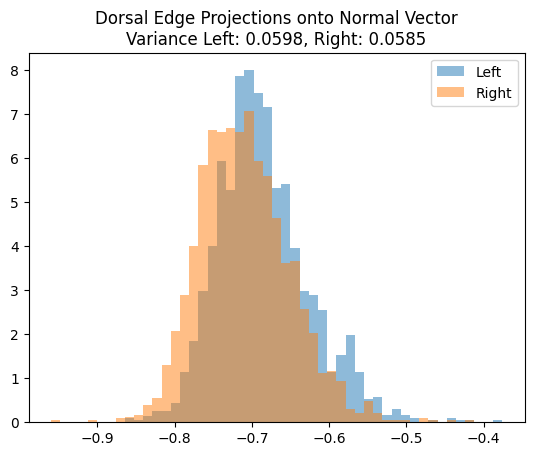

In [62]:
# assume dorsal edge is a plane, infer the normal vector using pca
from sklearn.decomposition import PCA
dorsal_edge_ccfs_flip = dorsal_edge_ccfs.copy()
dorsal_edge_ccfs_flip[:, ml] = np.abs(dorsal_edge_ccfs_flip[:, ml])
pca = PCA(n_components=3)
pca.fit(dorsal_edge_ccfs_flip)
normal_vector = pca.components_[-1]
print("Normal vector of dorsal edge plane:", normal_vector)
# project dorsal edge points onto the normal vector
dorsal_edge_proj_left = dorsal_edge_ccfs_left @ normal_vector
dorsal_edge_proj_right = dorsal_edge_ccfs_right @ normal_vector
var_l = np.var(dorsal_edge_proj_left)
sd_l = np.std(dorsal_edge_proj_left)
var_r = np.var(dorsal_edge_proj_right)
sd_r = np.std(dorsal_edge_proj_right)
# plot histogram of dorsal edge projections
plt.figure()
edges = np.linspace(min(dorsal_edge_proj_left.min(), dorsal_edge_proj_right.min()), max(dorsal_edge_proj_left.max(), dorsal_edge_proj_right.max()), 50)
plt.hist(dorsal_edge_proj_left, bins=edges, alpha=0.5, label='Left', density=True);
plt.hist(dorsal_edge_proj_right, bins=edges, alpha=0.5, label='Right', density=True);
plt.legend();
plt.title('Dorsal Edge Projections onto Normal Vector\nVariance Left: {:.4f}, Right: {:.4f}'.format(sd_l, sd_r))

Normal vector of dorsal surface plane: [0.90597767 0.03233549 0.42208871]


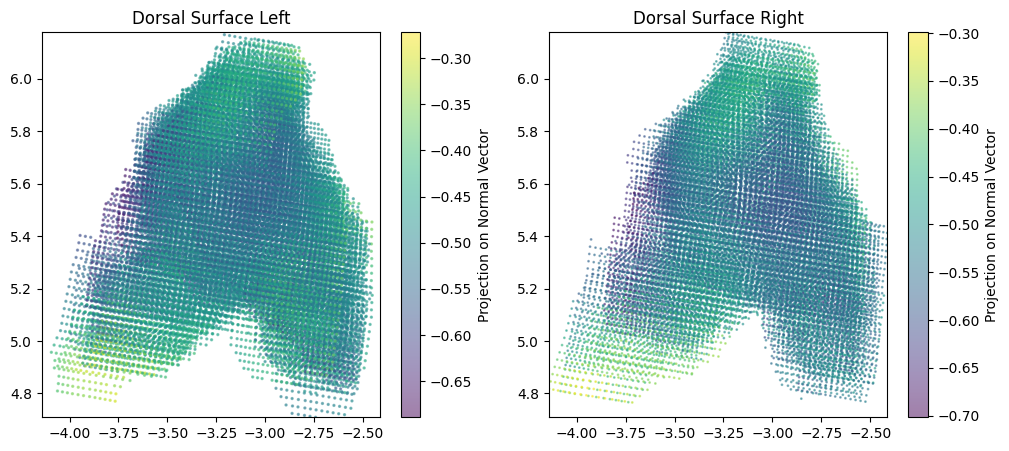

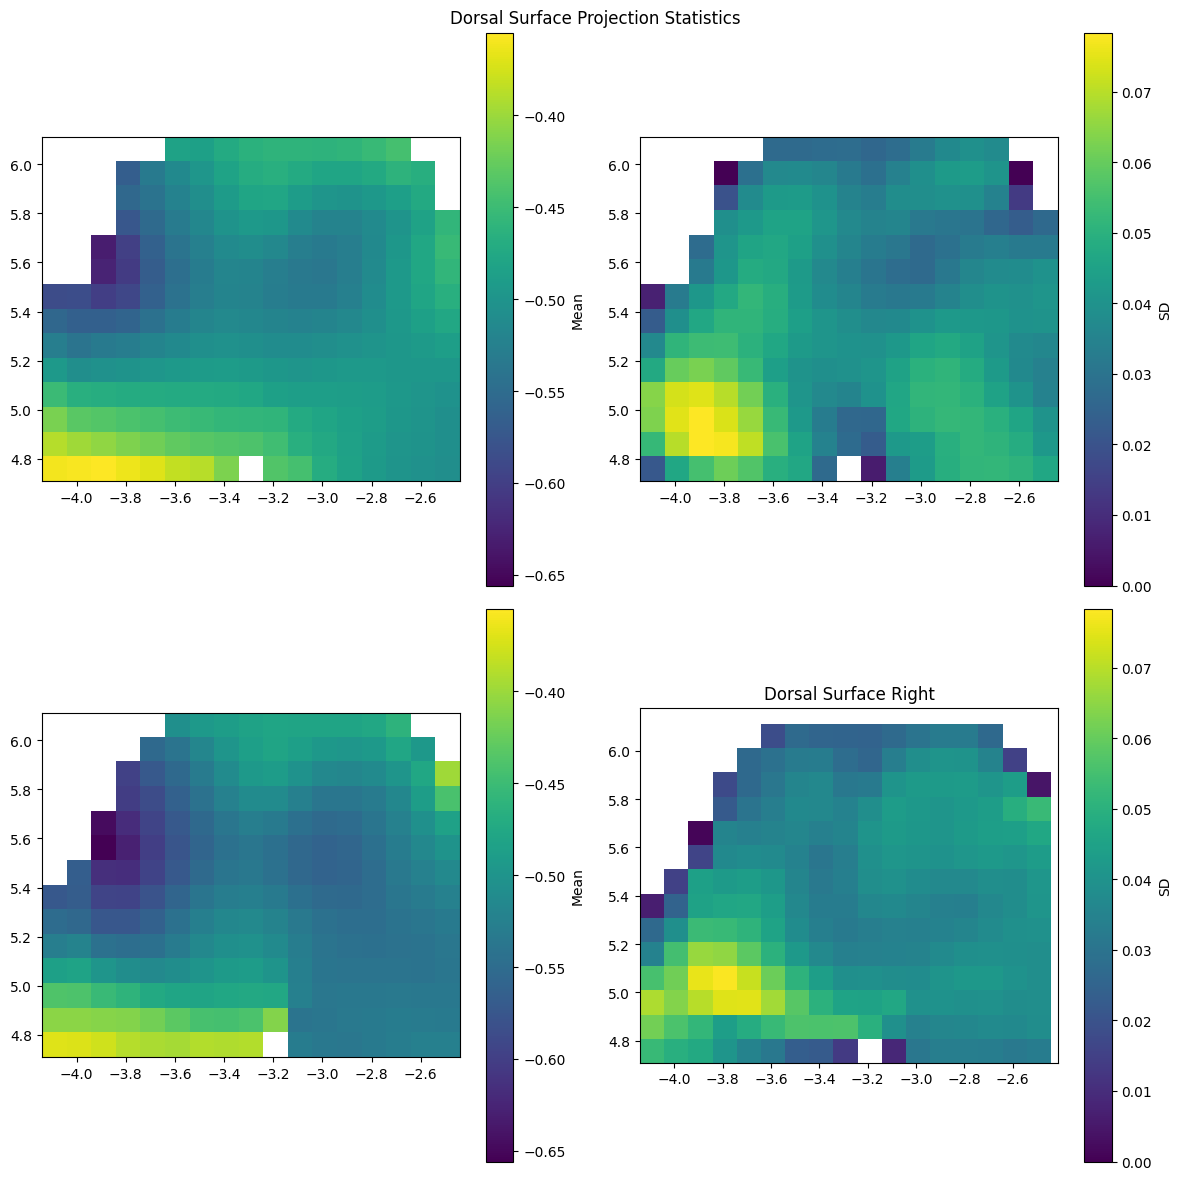

In [87]:
# infer the normal vector of the mesh using pca of the dorsal surface points
dorsal_surface_ccfs_all_flip = np.vstack([dorsal_surface_ccfs_L, dorsal_surface_ccfs_R])
dorsal_surface_ccfs_all = dorsal_surface_ccfs_all_flip.copy()
dorsal_surface_ccfs_all[len(dorsal_surface_ccfs_L):, ml] = -dorsal_surface_ccfs_all_flip[len(dorsal_surface_ccfs_L):, ml]
pca_surface = PCA(n_components=3)
pca_surface.fit(dorsal_surface_ccfs_all_flip)
normal_vector_surface = pca_surface.components_[-1]
print("Normal vector of dorsal surface plane:", normal_vector_surface)
# project dorsal surface points onto the normal vector
dorsal_surface_proj = dorsal_surface_ccfs_all_flip @ normal_vector_surface
# project dorsal surface onto the plane defined by the normal vector 1 and 2
dorsal_surface_proj_1 = dorsal_surface_ccfs_all_flip @ pca_surface.components_[0]
dorsal_surface_proj_2 = dorsal_surface_ccfs_all_flip @ pca_surface.components_[1]

xlim = (dorsal_surface_proj_1.min(), dorsal_surface_proj_1.max())
ylim = (dorsal_surface_proj_2.min(), dorsal_surface_proj_2.max())

# scatter proj_1 and proj_2 colored by proj on normal vector, separately for left and right on two plots
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
sc = ax.scatter(dorsal_surface_proj_1[dorsal_surface_ccfs_all[:, ml]>0], dorsal_surface_proj_2[dorsal_surface_ccfs_all[:, ml]>0], 
                c=dorsal_surface_proj[dorsal_surface_ccfs_all[:, ml]>0], cmap='viridis', s=2, alpha=0.5)
plt.colorbar(sc, label='Projection on Normal Vector')
plt.title('Dorsal Surface Left')
plt.xlim(xlim)
plt.ylim(ylim)
plt.subplot(1, 2, 2)
ax = plt.subplot(1, 2, 2)
sc = ax.scatter(dorsal_surface_proj_1[dorsal_surface_ccfs_all[:, ml]<0], dorsal_surface_proj_2[dorsal_surface_ccfs_all[:, ml]<0], 
                c=dorsal_surface_proj[dorsal_surface_ccfs_all[:, ml]<0], cmap='viridis', s=1, alpha=0.5)
plt.colorbar(sc, label='Projection on Normal Vector')
plt.title('Dorsal Surface Right')
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# plot mean and variance of retro ccf points from the dorsal surface plane binned by location of proj_1 and proj_2
bin_size = 0.2  # in mm
step_size = 0.1  # in mm
x_bins = np.arange(dorsal_surface_proj_1.min(), dorsal_surface_proj_1.max(), step_size)
y_bins = np.arange(dorsal_surface_proj_2.min(), dorsal_surface_proj_2.max(), step_size)
mean_proj_L = np.zeros((len(x_bins)-1, len(y_bins)-1))
var_proj_L = np.zeros((len(x_bins)-1, len(y_bins)-1))
mean_proj_R = np.zeros((len(x_bins)-1, len(y_bins)-1))
var_proj_R = np.zeros((len(x_bins)-1, len(y_bins)-1))
side_mask = dorsal_surface_ccfs_all[:, ml]>0
for i in range(len(x_bins)-1):
    for j in range(len(y_bins)-1):
        bin_mask = (dorsal_surface_proj_1 >= (x_bins[i]-0.5*bin_size)) & (dorsal_surface_proj_1 < (x_bins[i+1]+0.5*bin_size))& \
                   (dorsal_surface_proj_2 >= (y_bins[j]-0.5*bin_size)) & (dorsal_surface_proj_2 < (y_bins[j+1]+0.5*bin_size))
        # left
        if np.sum(bin_mask & side_mask) > 0:
            mean_proj_L[i, j] = np.mean(dorsal_surface_proj[bin_mask & side_mask])
            var_proj_L[i, j] = np.std(dorsal_surface_proj[bin_mask & side_mask])
        else:
            mean_proj_L[i, j] = np.nan
            var_proj_L[i, j] = np.nan
        # right
        if np.sum(bin_mask & ~side_mask) > 0:
            mean_proj_R[i, j] = np.mean(dorsal_surface_proj[bin_mask & ~side_mask])
            var_proj_R[i, j] = np.std(dorsal_surface_proj[bin_mask & ~side_mask])
        else:
            mean_proj_R[i, j] = np.nan
            var_proj_R[i, j] = np.nan

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# separate left and right
im1 = axes[0, 0].imshow(mean_proj_L.T, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], 
                vmin=min(np.nanmin(mean_proj_L), np.nanmin(mean_proj_R)), vmax=max(np.nanmax(mean_proj_L), np.nanmax(mean_proj_R)))
plt.colorbar(im1, ax=axes[0, 0], label='Mean')
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Dorsal Surface Left')
im2 = axes[0, 1].imshow(var_proj_L.T, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                vmin=(min(np.nanmin(var_proj_L), np.nanmin(var_proj_R))), vmax=max(np.nanmax(var_proj_L), np.nanmax(var_proj_R)))
plt.colorbar(im2, ax=axes[0, 1], label='SD')
plt.xlim(xlim)
plt.ylim(ylim)
im3 = axes[1, 0].imshow(mean_proj_R.T, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                vmin=min(np.nanmin(mean_proj_L), np.nanmin(mean_proj_R)), vmax=max(np.nanmax(mean_proj_L), np.nanmax(mean_proj_R)))
plt.colorbar(im3, ax=axes[1, 0], label='Mean')
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Dorsal Surface Right')
im4 = axes[1, 1].imshow(var_proj_R.T, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                vmin=min(np.nanmin(var_proj_L), np.nanmin(var_proj_R)), vmax=max(np.nanmax(var_proj_L), np.nanmax(var_proj_R)))
plt.colorbar(im4, ax=axes[1, 1], label='SD')
plt.xlim(xlim)
plt.ylim(ylim)
plt.suptitle('Dorsal Surface Projection Statistics')
plt.tight_layout()
plt.show()





Text(0.5, 1.0, 'Retro CCF Projections onto Dorsal Edge Normal Vector')

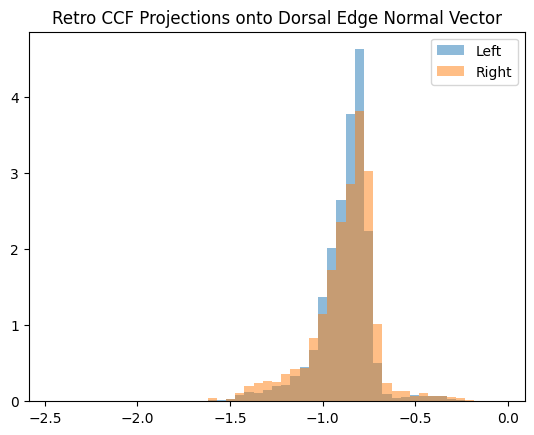

In [69]:
# Compare retro ccf points's left and right projections onto the normal vector
ccf_neurons_mm_L = ccf_neurons_mm[ccf_neurons_mm[:, ml]>0]
ccf_neurons_mm_R = ccf_neurons_mm[ccf_neurons_mm[:, ml]<0]
ccf_neurons_mm_R[:, ml] = -ccf_neurons_mm_R[:, ml]
ccf_proj_L = ccf_neurons_mm_L @ normal_vector
ccf_proj_R = ccf_neurons_mm_R @ normal_vector
# plot histogram of retro ccf projections
plt.figure()
edges = np.linspace(min(ccf_proj_L.min(), ccf_proj_R.min()), max(ccf_proj_L.max(), ccf_proj_R.max()), 50)
plt.hist(ccf_proj_L, bins=edges, alpha=0.5, label='Left', density=True);
plt.hist(ccf_proj_R, bins=edges, alpha=0.5, label='Right', density=True);
plt.legend();
plt.title('Retro CCF Projections onto Dorsal Edge Normal Vector')


# Compare with behavior

In [111]:
beh_features_combined_file = '/root/capsule/scratch/combined/beh_plots/beh_all/features_combined_beh_all.pkl' 
with open(features_combined_file, 'rb') as f:
    beh_combined = pd.read_pickle(f)
ccfs = beh_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = np.abs(ccfs[:, ml]) 

In [205]:
ccf_neurons_mm_flip = ccf_neurons_mm.copy()
ccf_neurons_mm_flip[:, ml] = np.abs(ccf_neurons_mm_flip[:, ml])  # mirror to one side for cca projection

In [113]:
# plot ccfs with mesh and retro ccf
plot = k3d.plot()
# transparent gray mesh
plot += k3d.points(mesh_vertices_lps.astype(np.float32), point_size=0.01, shader='flat', color=0xAAAAAA, opacity=0.1, name='CCF Mesh')
# plot retro ccf ccf points
plot += k3d.points(ccf_neurons_mm_flip.astype(np.float32), point_size=0.005, shader='flat', color=0xFF0000, name='Retro CCF', opacity=0.5)
# plot beh ccfs points
plot += k3d.points(ccfs.astype(np.float32), point_size=0.05, shader='flat', color=0x0000FF, name='Beh CCF', opacity=0.5)
plot.display()

Output()

In [177]:
beh_location_tree = cKDTree(ccfs[~np.isnan(ccfs[:, ml]), :])
distance = 0.1
close_mask, _ = beh_location_tree.query(ccf_neurons_mm_flip, k=1)  # only infer for points within 0.3 mm of any beh point
close_mask = close_mask<distance

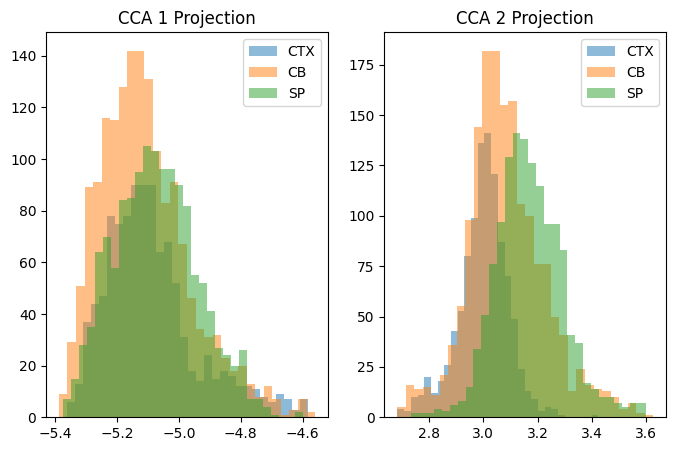

In [181]:
# plot distibution of projection targets along cca1 and cca2
cca_1 = np.array([-0.2636, -0.9645, -0.0140])
cca_2 = np.array([-0.7005, 0.2014, -0.6847])

ccf_neurons_mm_flip = ccf_neurons_mm.copy()
ccf_neurons_mm_flip[:, ml] = np.abs(ccf_neurons_mm_flip[:, ml])  # mirror to one side for cca projection
cca_1_proj = ccf_neurons_mm_flip @ cca_1
cca_2_proj = ccf_neurons_mm_flip @ cca_2

fig, axes = plt.subplots(1, 2, figsize=(8, 5))
for ind, tar in enumerate(retro_ccf['injection_region'].unique()):
    if tar != 'TH':
        mask = (retro_ccf['injection_region'] == tar)
        axes[0].hist(cca_1_proj[mask & close_mask], bins=30, alpha=0.5, label=tar)
        axes[1].hist(cca_2_proj[mask & close_mask], bins=30, alpha=0.5, label=tar)
axes[0].set_title('CCA 1 Projection')
axes[1].set_title('CCA 2 Projection')
axes[0].legend()
axes[1].legend()
plt.show()

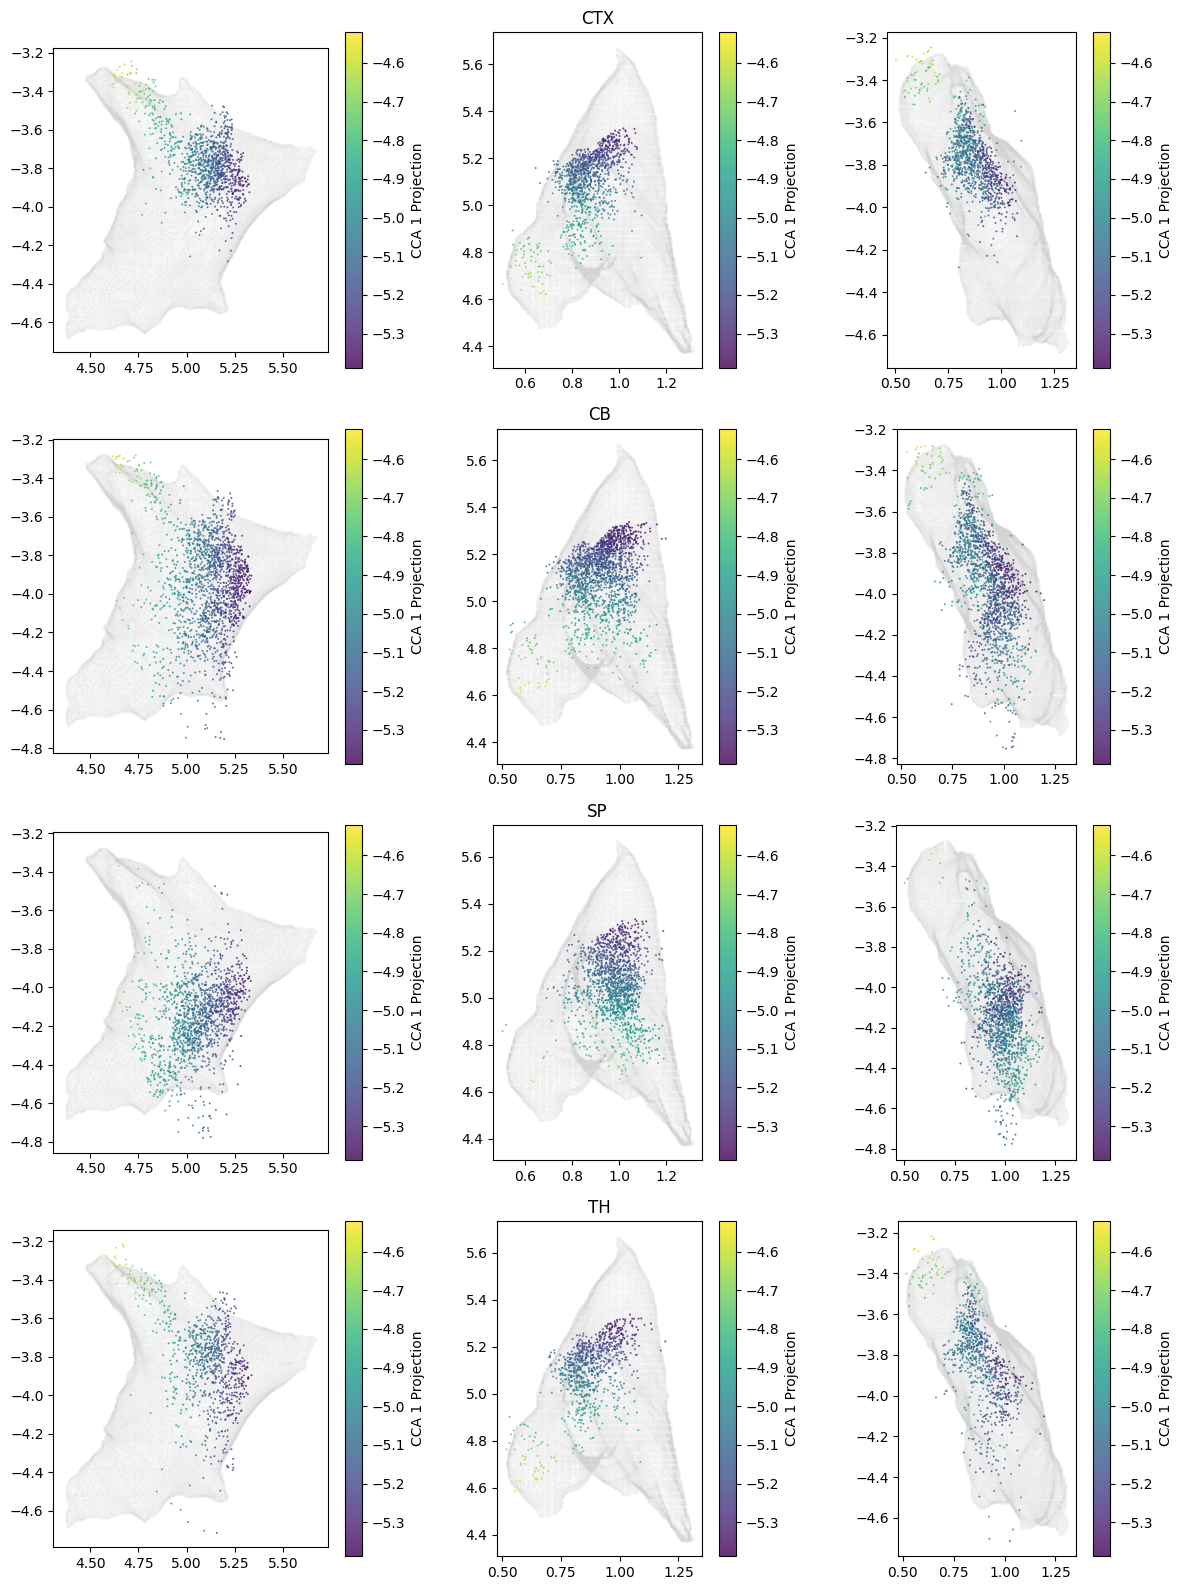

In [180]:
# color code points by their projection on cca1 and cca2
fig = plt.figure(figsize=(12, 4*len(retro_ccf['injection_region'].unique())))
gs = fig.add_gridspec(len(retro_ccf['injection_region'].unique()), 3)
norm = Normalize(vmin=np.min(cca_1_proj[close_mask]), vmax=np.max(cca_1_proj[close_mask]))
for plane, ax_ind in zip(planes.keys(), range(3)):
    # ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    for ind, tar in enumerate(retro_ccf['injection_region'].unique()):
        mask = (retro_ccf['injection_region'] == tar)
        ax = fig.add_subplot(gs[ind, ax_ind])
        ax.scatter(mesh_vertices_lps[:, planes[plane][0]], mesh_vertices_lps[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.1)
        
        sc = ax.scatter(ccf_neurons_mm_flip[mask & close_mask, planes[plane][0]], ccf_neurons_mm_flip[mask & close_mask, planes[plane][1]], c=cca_1_proj[mask & close_mask], cmap='viridis', alpha=0.8, s=2, edgecolor='none', label=tar, norm=norm)
        plt.colorbar(sc, ax=ax, label='CCA 1 Projection')
        ax.set_aspect(aspect='equal')
        if plane == 'hor':
            ax.set_title(tar)
    # ax.set_title(plane)
plt.tight_layout()
plt.show()

In [114]:
beh_features = ['T_outcome:ipsi_com_mc',
                'T_outcome_l_mc',
                'T_outcome_com_mc',
                'T_ipsi_com_mc',
                'T_ipsi_l_mc',
                'T_response_hit_all',
                'T_response_svs_hit',
                'T_response_ipsi_hit',
                'T_response_ipsi:svs_hit']

In [183]:
# for each feature, x = [ccf in 3 dimensions], y = [feature value], infer feature value of neurons in retro_ccf using rbf
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feature_projections = {}

beh_location_tree = cKDTree(ccfs[~np.isnan(ccfs[:, ml]), :])
distance = 0.1
close_mask, _ = beh_location_tree.query(ccf_neurons_mm_flip, k=1)  # only infer for points within 0.3 mm of any beh point
close_mask = close_mask<distance
for feature in beh_features:
    feature_values = beh_combined[feature].values
    valid_mask = ~np.isnan(feature_values) & ~np.isnan(ccfs[:, ml])
    rbf = RBFInterpolator(
        ccfs[valid_mask], feature_values[valid_mask],
        kernel="gaussian",   
        smoothing=0.5,                # 0 == interpolate exactly
        neighbors=3,            # tune: 20–100 typical
        epsilon=0.5 
    )
    # infer feature values for retro ccf neurons
    inferred_values = rbf(ccf_neurons_mm_flip)
    inferred_values[~close_mask] = np.nan  # set to nan if not close to any beh point
    feature_projections[feature] = inferred_values

In [188]:
import matplotlib.gridspec as gridspec
regions = ['CTX', 'SP', 'CB']
custom_cmap = LinearSegmentedColormap.from_list(
    'blue_white_red', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
)
for test_feature in beh_features:
    fig = plt.figure(figsize=(18, 15))
    gs = gridspec.GridSpec(len(regions)+1, len(planes))
    max_scale = np.nanmax(np.abs(feature_projections[test_feature][close_mask]))
    norm = Normalize(vmin=-max_scale, vmax=max_scale)
    ax_hist = fig.add_subplot(gs[-1, 0])
    edges = np.linspace(np.min(feature_projections[test_feature][close_mask])-0.01, np.max(feature_projections[test_feature][close_mask])+0.01, 20)
    for tar_ind, tar in enumerate(regions):
        mask = (retro_ccf['injection_region'] == tar)
        for i, plane in enumerate(planes.keys()):
            ax = fig.add_subplot(gs[tar_ind, i])
            sc = ax.scatter(ccf_neurons_mm_flip[mask, planes[plane][0]], ccf_neurons_mm_flip[mask, planes[plane][1]], 
                        c=feature_projections[test_feature][mask], cmap=custom_cmap, s=2, alpha=0.6, label=tar, norm=norm)
            # scatter mesh
            ax.scatter(mesh_vertices_mm_left[:, planes[plane][0]], mesh_vertices_mm_left[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.1)
            if i == 0:
                ax.set_ylabel(tar)
                plt.colorbar(sc, ax=ax, label=test_feature)
            ax.set_aspect(aspect='equal')
        if tar != 'CB':
            ax_hist.hist(feature_projections[test_feature][mask & close_mask], bins=edges, alpha=0.7, label=tar)
    ax_hist.legend()
    # Compare if distribution of feature projections are different between CTX and SP
    ctx_mask = (retro_ccf['injection_region'] == 'CTX') & close_mask
    sp_mask = (retro_ccf['injection_region'] == 'SP') & close_mask
    t_stat, p_value = ttest_ind(feature_projections[test_feature][ctx_mask], feature_projections[test_feature][sp_mask], nan_policy='omit')
    ax_hist.set_title(f'Histogram (p-value CTX vs SP: {p_value:.4f})')
    plt.suptitle(f'Inferred {test_feature} on Retro CCF Neurons')
    plt.tight_layout()
    fig.savefig(fname=os.path.join(save_dir, f'{test_feature}_inferred_on_retro_ccf.png'), dpi=300)
    fig.savefig(fname=os.path.join(save_dir, f'{test_feature}_inferred_on_retro_ccf.pdf'))
    plt.close(fig)

In [57]:
# Step 4: Get the primary axis of variation
# LDA provides a linear discriminant, which can be interpreted as the primary axis of variation
primary_axis_vector = lda.scalings_[:, 0]  # First linear discriminant

# Normalize the vector for better interpretation
primary_axis_vector_LDA = primary_axis_vector / np.linalg.norm(primary_axis_vector)
 
# Display the primary axis of variation
print("Primary axis of variation :", primary_axis_vector_LDA)


Primary axis of variation : [0.22827885 0.95594934 0.1845254 ]


# Infer waveform properties

In [202]:
# load waveforms
waveform_criteria = 'waveform_all'
waveform_type = '_raw'
wf_folder  = os.path.join('/root/capsule/scratch/combined/wf_plots', waveform_criteria, waveform_type)
wf_feature_file = os.path.join(wf_folder, 'wf_features_combined.pkl')
with open(wf_feature_file, 'rb') as f:
    wf_features = pickle.load(f)
wf_features.rename(columns={'unit': 'unit_id'}, inplace=True)
wf_features['unit_id'] = wf_features['unit_id'].apply(to_str_intlike)
wf_features.drop(columns=['probe'], inplace=True)

features_wf = wf_features.columns.to_list()
features_wf.remove('session')
features_wf.remove('unit_id')
features_wf.remove('wf')
# features_wf.remove('gmm_label')
# features_wf.remove('kmeans_label')
# features_wf.remove('gmm_conf')
features_wf.remove('y_loc')
# features_wf.remove('probe')
features_wf.remove('peak')
features_wf.remove('amp')

with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)

wf_features = wf_features.merge(combined_tagged_units[['session', 'unit_id', 'x_ccf', 'y_ccf', 'z_ccf']], on=['session', 'unit_id'], how='left')

In [203]:
ccfs = wf_features[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])

In [206]:
# generate close_mask for wf features
beh_location_tree = cKDTree(ccfs[~np.isnan(ccfs[:, ml]), :])
distance = 0.1
close_mask, _ = beh_location_tree.query(ccf_neurons_mm_flip, k=1)  # only infer for points within 0.1 mm of any beh point
close_mask = close_mask<distance

In [207]:
# infer each wf feature on retro ccf neurons
wf_feature_projections = {}
for feature in features_wf:
    feature_values = wf_features[feature].values
    valid_mask = ~np.isnan(feature_values) & ~np.isnan(ccfs[:, ml])
    rbf = RBFInterpolator(
        ccfs[valid_mask], feature_values[valid_mask],
        kernel="gaussian",   
        smoothing=0.5,                # 0 == interpolate exactly
        neighbors=3,            # tune: 20–100 typical
        epsilon=0.5 
    )
    # infer feature values for retro ccf neurons
    inferred_values = rbf(ccf_neurons_mm_flip)
    inferred_values[~close_mask] = np.nan  # set to nan if not close to any beh point
    wf_feature_projections[feature] = inferred_values

In [213]:
# plot each wf feature on retro ccf neurons
import matplotlib.gridspec as gridspec
regions = ['CTX', 'SP', 'CB']
custom_cmap = LinearSegmentedColormap.from_list('gray_red', [(0.0, 'gray'), (1.0, 'red')])
for test_feature in features_wf:
    fig = plt.figure(figsize=(18, 15))
    gs = gridspec.GridSpec(len(regions)+1, len(planes))
    norm = Normalize(vmin=np.nanmin(wf_feature_projections[test_feature][close_mask]), vmax=np.nanmax(wf_feature_projections[test_feature][close_mask]))
    ax_hist = fig.add_subplot(gs[-1, 0])
    edges = np.linspace(np.min(wf_feature_projections[test_feature][close_mask])-0.01, np.max(wf_feature_projections[test_feature][close_mask])+0.01, 20)
    for tar_ind, tar in enumerate(regions):
        mask = (retro_ccf['injection_region'] == tar)
        for i, plane in enumerate(planes.keys()):
            ax = fig.add_subplot(gs[tar_ind, i])
            sc = ax.scatter(ccf_neurons_mm_flip[mask, planes[plane][0]], ccf_neurons_mm_flip[mask, planes[plane][1]], 
                        c=wf_feature_projections[test_feature][mask], cmap=custom_cmap, s=2, alpha=0.6, label=tar, norm=norm)
            # scatter mesh
            ax.scatter(mesh_vertices_mm_left[:, planes[plane][0]], mesh_vertices_mm_left[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.1)
            if i == 0:
                ax.set_ylabel(tar)
                plt.colorbar(sc, ax=ax, label=test_feature)
            ax.set_aspect(aspect='equal')
        if tar != 'CB':
            ax_hist.hist(wf_feature_projections[test_feature][mask & close_mask], bins=edges, alpha=0.7, label=tar)
    ax_hist.legend()
    # ttest
    ctx_mask = (retro_ccf['injection_region'] == 'CTX') & close_mask
    sp_mask = (retro_ccf['injection_region'] == 'SP') & close_mask
    t_stat, p_value = ttest_ind(wf_feature_projections[test_feature][ctx_mask], wf_feature_projections[test_feature][sp_mask], nan_policy='omit')
    ax_hist.set_title(f'Histogram (p-value CTX vs SP: {p_value:.4f})')
    plt.suptitle(f'Inferred {test_feature} on Retro CCF Neurons')
    plt.tight_layout()
    fig.savefig(fname=os.path.join(save_dir, f'{test_feature}_inferred_on_retro_ccf.png'), dpi=300)
    fig.savefig(fname=os.path.join(save_dir, f'{test_feature}_inferred_on_retro_ccf.pdf'))
    plt.close(fig)

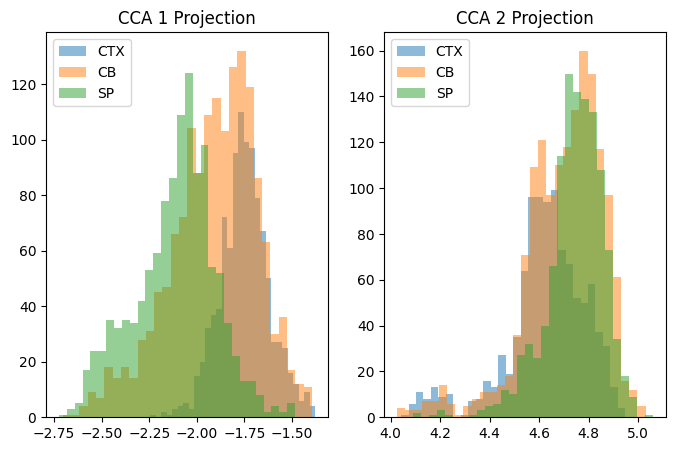

In [212]:
# project to cca axes and plot histograms
cca_1 = np.array([-0.1449, 0.3623, 0.9207])
cca_2 = np.array([0.7233, 0.6738, -0.1512])
cca_1_proj = ccf_neurons_mm_flip @ cca_1
cca_2_proj = ccf_neurons_mm_flip @ cca_2

fig, axes = plt.subplots(1, 2, figsize=(8, 5))
for ind, tar in enumerate(retro_ccf['injection_region'].unique()):
    if tar != 'TH':
        mask = (retro_ccf['injection_region'] == tar)
        axes[0].hist(cca_1_proj[mask & close_mask], bins=30, alpha=0.5, label=tar)
        axes[1].hist(cca_2_proj[mask & close_mask], bins=30, alpha=0.5, label=tar)
axes[0].set_title('CCA 1 Projection')
axes[1].set_title('CCA 2 Projection')
axes[0].legend()
axes[1].legend()
fig.savefig(fname=os.path.join(save_dir, f'wf_cca1_cca2_projection_histograms.png'), dpi=300)
fig.savefig(fname=os.path.join(save_dir, f'wf_cca1_cca2_projection_histograms.pdf'))
plt.show()


# Infer primary from regression

In [214]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm

# filter = projection_regions != 'TH'
filter = ((projection_regions == 'CTX') | (projection_regions == 'SP')) & (ccf_neurons_mm[:, dv_mesh] <= 4.8)
# Assume X is your features and y is binary or multiclass target
ccf_neurons_mm_with_const = sm.add_constant(ccf_neurons_mm)  # Add intercept
projection_regions_bin = projection_regions == 'SP'
# model = sm.MNLogit(projection_regions[filter], ccf_neurons_mm_with_const[filter])  # For multinomial; use sm.Logit for binary
model = sm.Logit(projection_regions_bin[filter], ccf_neurons_mm_with_const[filter]) 
result = model.fit()

# Get 95% confidence intervals
ci = result.conf_int(alpha=0.05)
primary_axis_vector_MLR = result.params[1:] * np.sign(result.params[2])  # First linear discriminant
primary_axis_vector_MLR = primary_axis_vector_MLR / np.linalg.norm(primary_axis_vector_MLR)
# Display the primary axis of variation
print("Primary axis of variation (in MLR space):", primary_axis_vector_MLR)

NameError: name 'dv_mesh' is not defined

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm

# filter = projection_regions != 'TH'
filter = ((projection_regions == 'CTX') | (projection_regions == 'SP')) & (ccf_neurons_mm[:, dv_mesh] <= 4.8)
# Assume X is your features and y is binary or multiclass target
ccf_neurons_mm_with_const = sm.add_constant(ccf_neurons_mm)  # Add intercept
projection_regions_bin = projection_regions == 'SP'

model = sm.OLS(projection_regions_bin[filter], ccf_neurons_mm_with_const[filter])
# model = sm.Logit(projection_regions_bin[filter], ccf_neurons_mm_with_const[filter])  # For binary logistic regression
model = model.fit()
print(model.summary())
print(model.params[1:]/np.linalg.norm(model.params[1:]))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     2512.
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        23:55:35   Log-Likelihood:                -1501.2
No. Observations:                5302   AIC:                             3010.
Df Residuals:                    5298   BIC:                             3037.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2833      0.134    -17.039      0.0

In [46]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5302
Model:                          Logit   Df Residuals:                     5298
Method:                           MLE   Df Model:                            3
Date:                Tue, 10 Jun 2025   Pseudo R-squ.:                  0.6413
Time:                        23:47:06   Log-Likelihood:                -1317.6
converged:                       True   LL-Null:                       -3673.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.5355      2.098     -6.929      0.000     -18.647     -10.424
x1             5.1088      0.339     15.074      0.000       4.445       5.773
x2             9.2369      0.356     25.937      0.0

In [43]:
model.params

array([-2.28332857,  0.25583379,  1.07133945,  0.20679897])

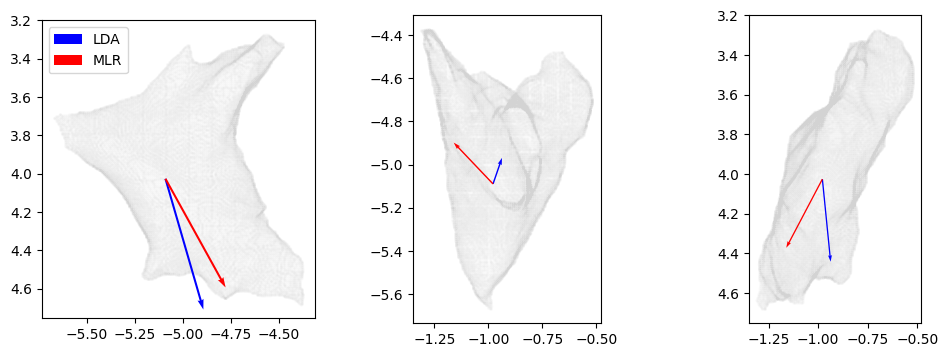

In [14]:
# plot the two axis in 2D ccf space
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 3)
for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.1, s = 0.1)
    # sc = ax.scatter(ccf_neurons_mm[mask, planes_mesh[plane][0]], ccf_neurons_mm[mask, planes_mesh[plane][1]], color='r', alpha=0.2, s=1, edgecolor='none', label=tar)
    if planes[plane][1] == dv:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_LDA[planes_mesh[plane][0]], -primary_axis_vector_LDA[planes_mesh[plane][1]],scale=2, color='blue', label='LDA')
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], -primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='red', label='MLR')
    else:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_LDA[planes_mesh[plane][0]], primary_axis_vector_LDA[planes_mesh[plane][1]],scale=2, color='blue', label='LDA')
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='red', label='MLR')
    ax.set_aspect(aspect='equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    # ax.set_title(plane)
    if plane == 'sag':
        ax.legend()

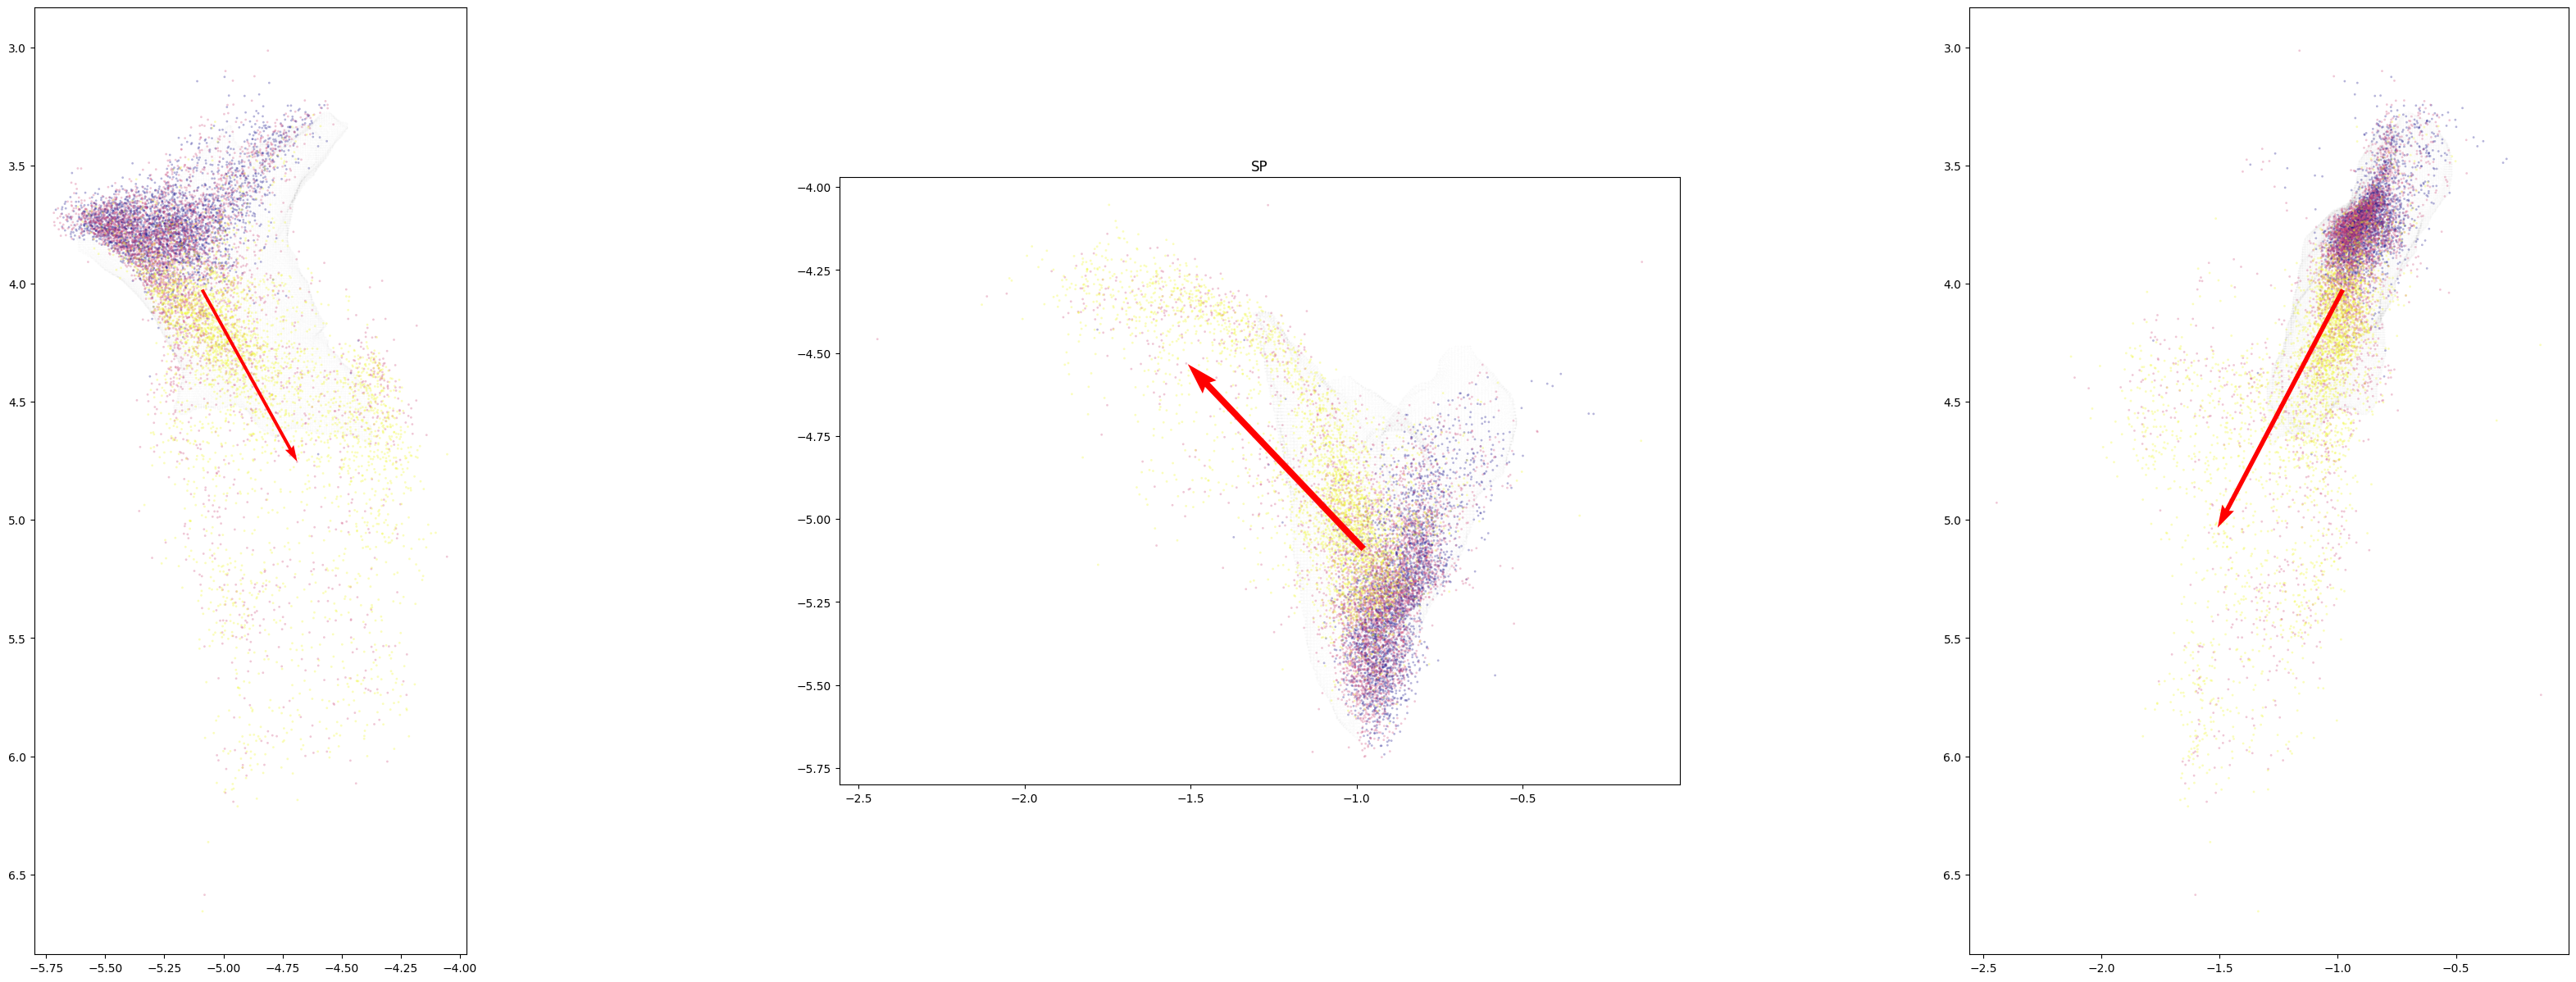

In [15]:
fig = plt.figure(figsize=(45, 15))
gs = fig.add_gridspec(1, 3)
from matplotlib.cm import plasma
from matplotlib.colors import to_hex

category_order = ['CTX', 'CB', 'SP']
category_to_index = {cat: i for i, cat in enumerate(category_order)}

# Normalize indices to [0, 1] for colormap
norm_indices = [category_to_index[cat] / (len(category_order) - 1) for cat in category_order]
colors = [plasma(val) for val in norm_indices]

for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.1, s = 0.02)
    for ind, tar in enumerate(retro_ccf['injection_region'].unique()):
        mask = (retro_ccf['injection_region'] == tar)
        if tar == 'TH':
            continue
        sc = ax.scatter(ccf_neurons_mm[mask, planes_mesh[plane][0]], ccf_neurons_mm[mask, planes_mesh[plane][1]], color=colors[category_order.index(tar)], alpha=0.3, s=4, edgecolor='none', label=tar)
        ax.set_aspect(aspect='equal')
        if planes[plane][1] == dv:
            ax.invert_yaxis()
        if plane == 'hor':
            ax.set_title(tar)
    if planes[plane][1] == dv:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], -primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='red', label='MLR')
    else:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='red', label='MLR')
    # ax.set_title(plane)

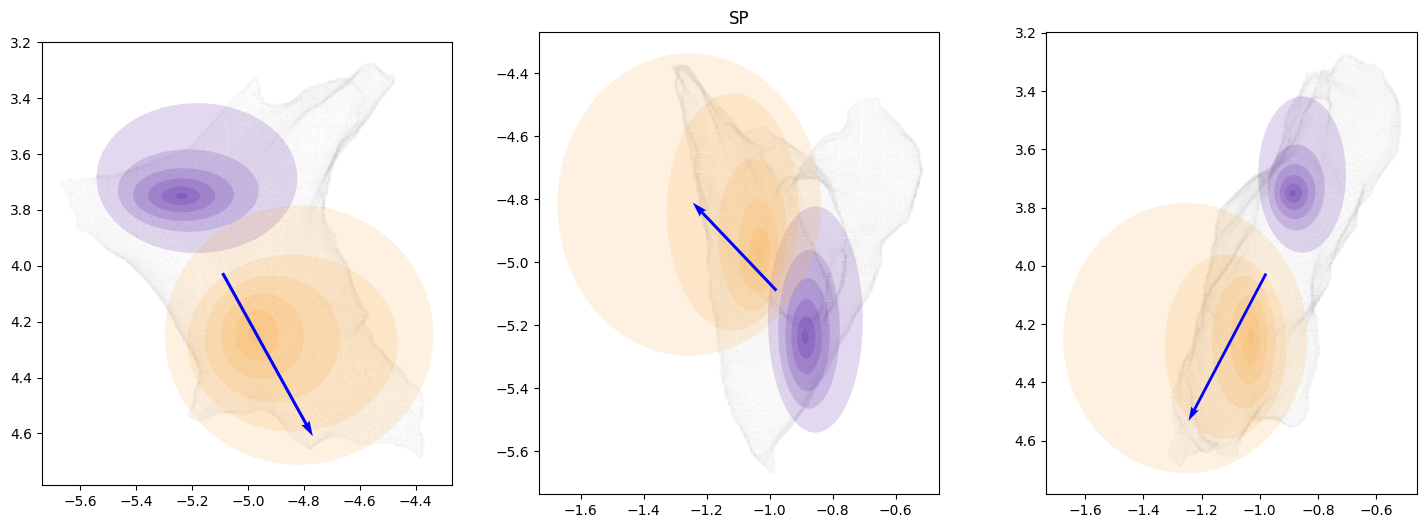

In [16]:
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3)
from matplotlib.cm import plasma
from matplotlib.colors import to_hex
from matplotlib.patches import Ellipse

category_order = ['CTX', 'SP']
category_to_index = {cat: i for i, cat in enumerate(category_order)}

# Normalize indices to [0, 1] for colormap
norm_indices = [0.1, 0.8]
colors = [plasma(val) for val in norm_indices]
ccf_neurons_mm_center_mask = ccf_neurons_mm[:, dv]<=4.8
centers =[np.mean(ccf_neurons_mm[(retro_ccf['injection_region'] == tar) & (ccf_neurons_mm_center_mask)], axis=0) for tar in category_order]
centers = np.array(centers)
bin_count = 12
pers = np.linspace(5, 95, bin_count)
sds = [np.percentile(ccf_neurons_mm[(retro_ccf['injection_region'] == tar) & (ccf_neurons_mm_center_mask)], pers, axis=0) for tar in category_order]
sds = np.array(sds)

for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.7, s = 0.002)
    for ind, tar in enumerate(category_order):
        for ind_per in range(int(0.5*bin_count)):
            inds = np.array([ind_per, bin_count-1-ind_per])
            center = np.mean(sds[ind, inds, planes_mesh[plane][0]]), np.mean(sds[ind, inds, planes_mesh[plane][1]])
            width = (sds[ind, bin_count-1-ind_per, planes_mesh[plane][0]] - sds[ind, ind_per, planes_mesh[plane][0]])
            height = (sds[ind, bin_count-1-ind_per, planes_mesh[plane][1]] - sds[ind, ind_per, planes_mesh[plane][1]])
            ellipse = Ellipse(xy=center, width=width, height=height,
                    edgecolor='none', facecolor=colors[ind], lw=2, alpha=0.15, label=tar)
            ax.add_patch(ellipse)
    ax.set_aspect(aspect='equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    if plane == 'hor':
        ax.set_title(tar)
    if planes[plane][1] == dv:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], -primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='b', label='MLR')
    else:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='b', label='MLR')
    # ax.set_title(plane)
plt.savefig(os.path.join('/root/capsule/scratch/combined/ccf_maps', 'CTX_SP_2d_projection_no_arrow.pdf'), dpi=300, bbox_inches='tight')


In [17]:
ccf_neurons_mm_center_mask = ccf_neurons_mm[:, dv]<=4.8
df = pd.DataFrame({'region': projection_regions[(projection_regions != 'TH') & (ccf_neurons_mm_center_mask)]})
proj_regions_dummy = pd.get_dummies(df['region']).values
# proj_regions_dummy = proj_regions_dummy[:, :2]  # Remove the last column
proj_regions_dummy = np.delete(proj_regions_dummy, 0, axis=1)  # Remove the first column for redundancy
# proj_regions_dummy = np.concatenate((proj_regions_dummy, -0.4*proj_regions_dummy), axis=1)
ccf_neurons_mm_focus = ccf_neurons_mm[(projection_regions != 'TH') & (ccf_neurons_mm_center_mask)]


In [18]:
# perform cca on dimension data and projection data
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
Xc = StandardScaler(with_std=False).fit_transform(ccf_neurons_mm_focus)  # center only
Yc = StandardScaler(with_std=False).fit_transform(proj_regions_dummy)
cca = CCA(n_components=1)
cca_result = cca.fit(Xc, Yc)

In [19]:
primary_axis_vector_cca = cca.x_weights_[:, 0]  # First canonical component

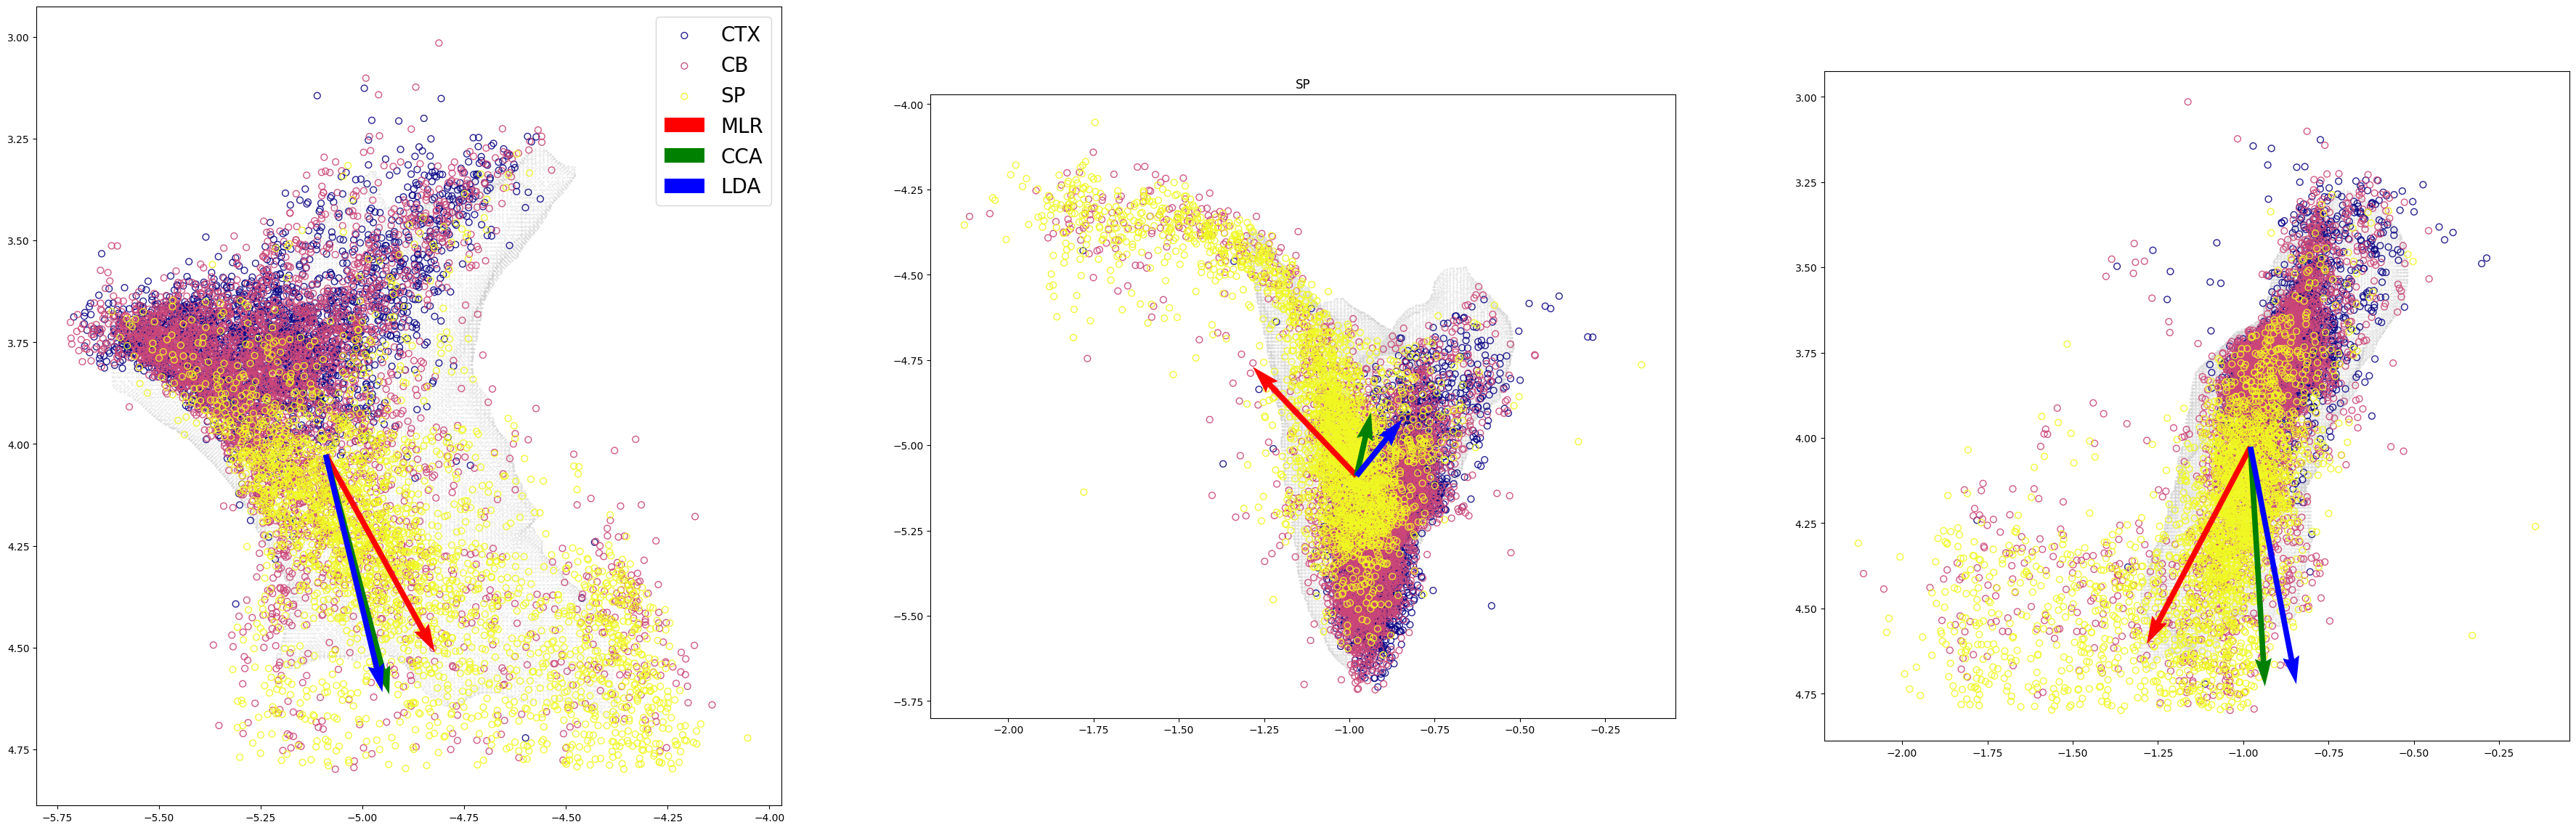

In [26]:
fig = plt.figure(figsize=(45, 15))
gs = fig.add_gridspec(1, 3)
from matplotlib.cm import plasma
from matplotlib.colors import to_hex

category_order = ['CTX', 'CB', 'SP']
category_to_index = {cat: i for i, cat in enumerate(category_order)}

# Normalize indices to [0, 1] for colormap
norm_indices = [category_to_index[cat] / (len(category_order) - 1) for cat in category_order]
colors = [plasma(val) for val in norm_indices]

for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=1, s = 0.05)
    for ind, tar in enumerate(retro_ccf['injection_region'].unique()):
        mask = (retro_ccf['injection_region'] == tar) & (ccf_neurons_mm[:, dv_mesh] <= 4.8)
        if tar == 'TH':
            continue
        sc = ax.scatter(ccf_neurons_mm[mask, planes_mesh[plane][0]], ccf_neurons_mm[mask, planes_mesh[plane][1]], color='none', alpha=0.9, s=40, edgecolor=colors[category_order.index(tar)], label=tar, linewidths=1)
        ax.set_aspect(aspect='equal')
        if planes[plane][1] == dv:
            ax.invert_yaxis()
        if plane == 'hor':
            ax.set_title(tar)
    if planes[plane][1] == dv:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], -primary_axis_vector_MLR[planes_mesh[plane][1]],scale=3, color='red', label='MLR')
    else:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], primary_axis_vector_MLR[planes_mesh[plane][1]],scale=3, color='red', label='MLR')
    # ax.set_title(plane)
    if planes[plane][1] == dv:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_cca[planes_mesh[plane][0]], -primary_axis_vector_cca[planes_mesh[plane][1]],scale=3, color='green', label='CCA')
    else:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_cca[planes_mesh[plane][0]], primary_axis_vector_cca[planes_mesh[plane][1]],scale=3, color='green', label='CCA')
    
    if planes[plane][1] == dv:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_LDA[planes_mesh[plane][0]], -primary_axis_vector_LDA[planes_mesh[plane][1]],scale=3, color='blue', label='LDA')
    else:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_LDA[planes_mesh[plane][0]], primary_axis_vector_LDA[planes_mesh[plane][1]],scale=3, color='blue', label='LDA')

    if plane == 'sag':
        ax.legend(fontsize=20, loc='upper right')
    

    